In [ ]:
#
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits, flux_to_mag, match_coord
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields, get_svfields_ij, gaiaAEN
from cuts import getGeoCuts, bgsbut
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin
from postages_images import postages_circle

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
from astropy.coordinates import SkyCoord
from astropy.table import Table, vstack
import astropy.units as units

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
#
dr1 = 'dr9k'
dr2 = 'dr9m'
survey = 'north' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'
Nranfiles = 3
reg = 'svfields_k'
dec_resol_ns = 32.375

pathdir = os.path.abspath(os.getcwd())+'/%s_%s-%s_%s_%s_comparison' %(dr1, dr2, survey, reg, version)
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)


In [3]:
%time cat1 = np.load(filesdir+dr1+'/'+version+'/'+'bgstargets-'+survey+'.npy')
#%time cat1_ex = np.load(filesdir+dr1+'/'+version+'/'+'extra-'+survey+'_n256.npy')

CPU times: user 17 ms, sys: 882 ms, total: 899 ms
Wall time: 1 s


In [4]:
%time cat2 = np.load(filesdir+dr2+'/'+version+'/'+'bgstargets-'+survey+'.npy')
#%time cat2_ex = np.load(filesdir+dr2+'/'+version+'/'+'extra-'+survey+'_n256.npy')

CPU times: user 13.3 ms, sys: 957 ms, total: 971 ms
Wall time: 1.01 s


In [5]:
#
if (dr1 in ['dr9i', 'dr9j']) or (dr2 in ['dr9i', 'dr9j']):
    
    cat1 = cat1[get_svfields_ij(cat1['RA'], cat1['DEC'], survey=survey)]
    cat2 = cat2[get_svfields_ij(cat2['RA'], cat2['DEC'], survey=survey)]
    

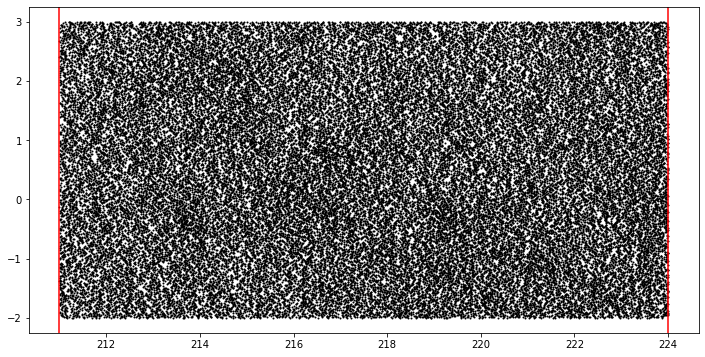

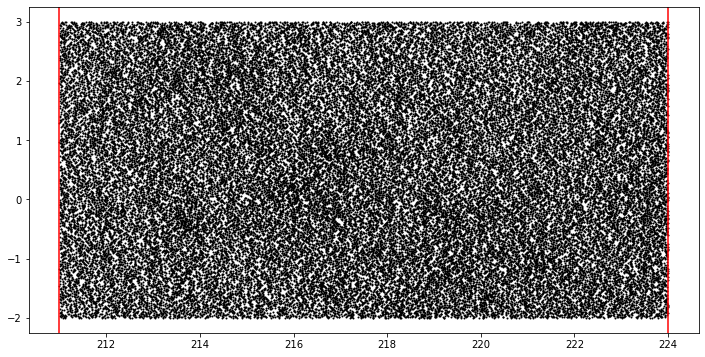

In [6]:
for cat in [cat1, cat2]:
    
    mask = cat['RMAG'] < 22
    #mask = np.ones_like(cat, dtype=bool)
    
    plt.figure(figsize=(12, 6))
    plt.scatter(cat['RA'][mask][::20], cat['DEC'][mask][::20], s=1, c='k')
    plt.axvline(211, color='r')
    plt.axvline(224, color='r')
    plt.show()

### outline

Comparing BGS galaxies in dr9f with dr9g around Medium bright Stars (MS) but excluding overlap with Bright stars (i.e. stars with 13 < G < 16 only) where dr9f uses "fit_back" but dr9g does not.

Ratio dr9f/dr9g for: 1) BGS within MS masking radius, and 2) outside the MS masking radius.
* south: dr9f/dr9g=xxx dr9f/dr9g=xxx
* north: dr9f/dr9g=xxx dr9f/dr9g=xxx

Agreement / disagrement in dr9f / disagrement in dr9g for 1) within MS masking and 2) outside MS masking
* south: agree. / dissagr.f  / dissagr.g agree. / dissagr.f  / dissagr.g
* north: agree. / dissagr.f  / dissagr.g agree. / dissagr.f  / dissagr.g

If dissagree why?
* % not in LS
* % with rmag > 20
* % rejected by a BGS cut

r-magnitude comparison plots. Left: within MS masking radius. Right: outside MS masking radius.
* plots r-dr9g vs r-dr9f - r-dr9g

I've made galleries with:
* Agreements
* BGS In dr9f not in dr9g
* BGS In dr9g not in dr9f
Color key is:
green: bgs in both
red: bgs in dr9f only
blue: bgs in dr9g only



In [7]:
#
if (dr1 in ['dr9i', 'dr9j']) or (dr2 in ['dr9i', 'dr9j']):
    if survey == 'north': area = 53
    elif survey == 'south': area = 65

else:
    if survey == 'north': area = 110
    elif survey == 'south': area = 182
        
print(area)

65


In [8]:
cats = {'dr9i':cat1, 'dr9j':cat2}

for catname, cat in zip(cats.keys(), cats.values()):
    
    bgs = ((cat['BGSBITS'] & 2**(20)) != 0) #BGS objects
    MS = ((cat['MASKBITS'] & 2**11)!=0) #within MS masking radius
    BS = ((cat['MASKBITS'] & 2**1)!=0) #within BS masking radius
    inMS = (bgs) & (MS) & (~BS)
    outMS = (bgs) & (~MS) & (~BS)
    PSF = cat['TYPE'] == 'PSF'
    
    print('%s-%s: \t %.2f(inMS) \t %.2f(outMS)' %(survey, catname, np.sum(inMS)/area, np.sum(outMS)/area))
    print('\t PSF:%s-%s: \t %.2f/(inMS) \t %.2f(outMS)' %(survey, catname, np.sum(inMS & PSF)/area, np.sum(outMS & PSF)/area))
    print('\t NO-PSF:%s-%s: \t %.2f/(inMS) \t %.2f(outMS)' %(survey, catname, np.sum(inMS & ~PSF)/area, np.sum(outMS & ~PSF)/area))
    

south-dr9i: 	 42.71(inMS) 	 1420.82(outMS)
	 PSF:south-dr9i: 	 0.09/(inMS) 	 2.83(outMS)
	 NO-PSF:south-dr9i: 	 42.62/(inMS) 	 1417.98(outMS)
south-dr9j: 	 47.83(inMS) 	 1420.66(outMS)
	 PSF:south-dr9j: 	 0.09/(inMS) 	 2.83(outMS)
	 NO-PSF:south-dr9j: 	 47.74/(inMS) 	 1417.83(outMS)


In [9]:
#
if True:
    idx2, idx1, d2d, d_ra, d_dec = match_coord(cat1['RA'], cat1['DEC'], cat2['RA'], cat2['DEC'], search_radius=0.5)
    
    #
    MSf = ((cat1['MASKBITS'] & 2**11)!=0) #within MS masking radius
    BSf = ((cat1['MASKBITS'] & 2**1)!=0) #within BS masking radius
    MSg = ((cat2['MASKBITS'] & 2**11)!=0) #within MS masking radius
    BSg = ((cat2['MASKBITS'] & 2**1)!=0) #within BS masking radius

    inMSf = (MSf) & (~BSf)
    inMSg = (MSg) & (~BSg)
    outMSf = (~MSf) & (~BSf)
    outMSg = (~MSg) & (~BSg)

Doubly matched objects = 11
Final matched objects = 5800762


In [10]:
#
def create_tab(cat1, cat2, idx1, idx2, cat1name, cat2name):
    
    tabmatch = Table()

    for key in cat1.dtype.names:
    
        tabmatch[key+'_%s' %(cat1name)] = cat1[key][idx1]
        tabmatch[key+'_%s' %(cat2name)] = cat2[key][idx2]
        
    tabmatch['dr9%s' %(cat1name)] = np.ones_like(cat1['RA'][idx1], dtype=bool)
    tabmatch['dr9%s' %(cat2name)] = np.ones_like(cat2['RA'][idx2], dtype=bool)
    
    print('tabmatched DONE...')
    
    tabf = Table()
    
    match_1 = np.zeros_like(cat1['DEC'], dtype=bool)
    match_1[idx1] = True
    df0 = np.ones(np.sum(~match_1), dtype=bool)
    df1 = np.full(np.sum(~match_1), np.nan) #z from gama
    df2 = np.full(np.sum(~match_1), np.nan, dtype=str) #z from gama
    
    for key in cat1.dtype.names:
        
        if isinstance(cat1[key][0], (str)): df = df2.copy()
        else: df = df1.copy()
            
        tabf[key+'_%s' %(cat1name)] = cat1[key][~match_1]
        if key in ['RA', 'DEC']: tabf[key+'_%s' %(cat2name)] = cat1[key][~match_1]
        else: tabf[key+'_%s' %(cat1name)] = df
    
    tabf['dr9%s' %(cat1name)] = df0
    tabf['dr9%s' %(cat2name)] = ~df0
    
    print('tabf DONE...')
    
    tabg = Table()
    
    match_2 = np.zeros_like(cat2['DEC'], dtype=bool)
    match_2[idx2] = True
    df0 = np.ones(np.sum(~match_2), dtype=bool)
    df1 = np.full(np.sum(~match_2), np.nan) #z from gama
    df2 = np.full(np.sum(~match_2), np.nan, dtype=str) #z from gama
    
    for key in cat2.dtype.names:
        
        if isinstance(cat2[key][0], (str)): df = df2.copy()
        else: df = df1.copy()
            
        if key in ['RA', 'DEC']: tabg[key+'_%s' %(cat1name)] = cat2[key][~match_2]
        else: tabg[key+'_%s' %(cat1name)] = df
        tabg[key+'_%s' %(cat2name)] = cat2[key][~match_2]
        
    tabg['dr9%s' %(cat1name)] = ~df0
    tabg['dr9%s' %(cat2name)] = df0
    
    print('tabg DONE...')
    
    tab = vstack([tabmatch, tabf, tabg])
    
    
    '''
    match = (tab['dr9%s' %(cat1name)]) & (tab['dr9%s' %(cat2name)])
    bgsf = ((np.uint64(tab['BGSBITS_%s' %(cat1name)]) & np.uint64(2**(20))) != 0)
    bgsg = ((np.uint64(tab['BGSBITS_%s' %(cat2name)]) & np.uint64(2**(20))) != 0)
    
    #get bgs matched in each catalogue:
    print('total matched: \t %i' %(np.sum(match)/area))
    
    print('\t & BGS_%s: \t %.3f' %(cat1name, np.sum((bgsf))/area))
    print('\t\t & BGS_%s & (BGS_%s): \t %.3f ' %(cat1name, cat2name, np.sum((match) & (bgsf) & (bgsg))/area))
    print('\t\t & BGS_%s & (~BGS_%s): \t %.3f ' %(cat1name, cat2name, np.sum((bgsf) & (~bgsg))/area))
    disag = np.sum((bgsf) & (~bgsg))
    print('\t\t\t & not in LS: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (~match))/disag))
    print('\t\t\t & rmag > 20: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (match) & (tab['RMAG_g'] > 20))/disag))
    print('\t\t\t & rmag < 20: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (match) & (tab['RMAG_g'] < 20))/disag))
    
    
    print('\t & BGS_%s: \t %.3f' %(cat2name, np.sum((bgsg))/area))
    print('\t\t & BGS_%s & (BGS_%s): \t %.3f ' %(cat2name, cat1name, np.sum((match) & (bgsg) & (bgsf))/area))
    print('\t\t & BGS_%s & (~BGS_%s): \t %.3f ' %(cat2name, cat1name, np.sum((bgsg) & (~bgsf))/area))
    disag = np.sum((bgsg) & (~bgsf))
    print('\t\t\t & not in LS: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (~match))/disag))
    print('\t\t\t & rmag > 20: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (match) & (tab['RMAG_f'] > 20))/disag))
    print('\t\t\t & rmag < 20: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (match) & (tab['RMAG_f'] < 20))/disag))
    '''
    
    return tab


In [11]:
#
def run2(tab=None, mask=None, cat1name=None, cat2name=None):
    
    if mask is None: mask = np.ones_like(tab, dtype=bool)
        
    match = (tab['dr9%s' %(cat1name)]) & (tab['dr9%s' %(cat2name)])
    bgsf = ((np.uint64(tab['BGSBITS_%s' %(cat1name)]) & np.uint64(2**(20))) != 0)
    bgsg = ((np.uint64(tab['BGSBITS_%s' %(cat2name)]) & np.uint64(2**(20))) != 0)
    
    #get bgs matched in each catalogue:
    print('total matched: \t %i' %(np.sum((match) & (mask))/area))
    
    print('\t & BGS_%s: \t %.3f' %(cat1name, np.sum((bgsf) & (mask))/area))
    print('\t\t & BGS_%s & (BGS_%s): \t %.3f ' %(cat1name, cat2name,np.sum((match) & (bgsf) & (bgsg) & (mask))/area))
    print('\t\t & BGS_%s & (~BGS_%s): \t %.3f ' %(cat1name, cat2name, np.sum((bgsf) & (~bgsg) & (mask))/area))
    disag = np.sum((bgsf) & (~bgsg) & (mask))
    print('\t\t\t & not in LS: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (~match) & (mask))/disag))
    print('\t\t\t & rmag > 20: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (match) & (tab['RMAG_%s' %(cat2name)] > 20) & (mask))/disag))
    print('\t\t\t & rmag < 20: \t %.3f %%' %(100*np.sum((bgsf) & (~bgsg) & (match) & (tab['RMAG_%s' %(cat2name)] < 20) & (mask))/disag))
    
    
    print('\t & BGS_%s: \t %.3f' %(cat2name, np.sum((bgsg) & (mask))/area))
    print('\t\t & BGS_%s & (BGS_%s): \t %.3f ' %(cat2name, cat1name, np.sum((match) & (bgsg) & (bgsf) & (mask))/area))
    print('\t\t & BGS_%s & (~BGS_%s): \t %.3f ' %(cat2name, cat1name, np.sum((bgsg) & (~bgsf) & (mask))/area))
    disag = np.sum((bgsg) & (~bgsf) & (mask))
    print('\t\t\t & not in LS: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (~match) & (mask))/disag))
    print('\t\t\t & rmag > 20: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (match) & (tab['RMAG_%s' %(cat1name)] > 20) & (mask))/disag))
    print('\t\t\t & rmag < 20: \t %.3f %%' %(100*np.sum((bgsg) & (~bgsf) & (match) & (tab['RMAG_%s' %(cat1name)] < 20) & (mask))/disag))
 

In [12]:
tab = create_tab(cat1=cat1, cat2=cat2, idx1=idx2, idx2=idx1, cat1name='i', cat2name='j')

tabmatched DONE...
tabf DONE...
tabg DONE...


In [13]:
if False:
    tab = np.load(pathdir+'/all.npy')
    #tab_in = np.load(pathdir+'/in.npy')
    #tab_out = np.load(pathdir+'/out.npy')

* All BGS in dr9g within MS
    * & outside BS
* All BGS in dr9f within MS
    * & outside BS
    
* matched & bgsg & ~bgsf & inMSf & inMSg
* matched & bgsg & ~bgsf & inMSf & inMSg & outBSg & outBSf
    
Apologies for the confussion, postages examples are centred in all BGS within the MS and does not exclude galaxies within the bright stars. However, the fraction of BGS

In [14]:
#

bgs2 = ((np.uint64(tab['BGSBITS_%s' %(dr2[-1])]) & np.uint64(2**(20))) != 0)
bgs1 = ((np.uint64(tab['BGSBITS_%s' %(dr1[-1])]) & np.uint64(2**(20))) != 0)
match = (tab['dr9%s' %(dr1[-1])]) & (tab['dr9%s' %(dr2[-1])])
MS1 = ((np.uint64(tab['MASKBITS_%s' %(dr1[-1])]) & np.uint64(2**11))!=0) #within MS masking radius
BS1 = ((np.uint64(tab['MASKBITS_%s' %(dr1[-1])]) & np.uint64(2**1))!=0) #within BS masking radius
MS2 = ((np.uint64(tab['MASKBITS_%s' %(dr2[-1])]) & np.uint64(2**11))!=0) #within MS masking radius
BS2 = ((np.uint64(tab['MASKBITS_%s' %(dr2[-1])]) & np.uint64(2**1))!=0) #within BS masking radius


In [15]:
mask = (match) & (bgs2) & (~bgs1) & ((MS1) | (MS2))
mask2 = (match) & (bgs2) & (~bgs1) & ((MS1) | (MS2)) & (~BS1) & (~BS2)
mask3 = (match) & (bgs2) & (~bgs1) & ((MS1) | (MS2)) & ((BS1) | (BS2))
print('bgs in dr9%s but not bgs in dr9%s' %(dr2[-1], dr1[-1]))
print('within MS in both \t within MS both & outside BS both \t within MS both & within BS both')
print(np.sum(mask), np.sum(mask2), np.sum(mask3))
print(np.sum(mask)/area, np.sum(mask2)/area, np.sum(mask3)/area)


bgs in dr9j but not bgs in dr9i
within MS in both 	 within MS both & outside BS both 	 within MS both & within BS both
701 701 0
13.226415094339623 13.226415094339623 0.0


In [16]:
mask = (~bgs2) & (bgs1) & ((MS1) | (MS2))
mask2 = (~bgs2) & (bgs1) & ((MS1) | (MS2)) & (~BS1) & (~BS2)
mask3 = (~bgs2) & (bgs1) & ((MS1) | (MS2)) & ((BS1) | (BS2))
print('bgs in dr9%s but not bgs in dr9%s' %(dr1[-1], dr2[-1]))
print('within MS in both \t within MS both & outside BS both \t within MS both & within BS both')
print(np.sum(mask), np.sum(mask2), np.sum(mask3))
print(np.sum(mask)/area, np.sum(mask2)/area, np.sum(mask3)/area)


bgs in dr9i but not bgs in dr9j
within MS in both 	 within MS both & outside BS both 	 within MS both & within BS both
126 125 1
2.3773584905660377 2.358490566037736 0.018867924528301886


In [17]:
#inside MS
run2(tab=tab, mask=(((MS1) | (MS2)) & (~BS1) & (~BS2)), cat1name=dr1[-1], cat2name=dr2[-1])

total matched: 	 1517
	 & BGS_i: 	 31.962
		 & BGS_i & (BGS_j): 	 29.604 
		 & BGS_i & (~BGS_j): 	 2.358 
			 & not in LS: 	 0.000 %
			 & rmag > 20: 	 85.600 %
			 & rmag < 20: 	 14.400 %
	 & BGS_j: 	 42.868
		 & BGS_j & (BGS_i): 	 29.604 
		 & BGS_j & (~BGS_i): 	 13.264 
			 & not in LS: 	 0.284 %
			 & rmag > 20: 	 98.435 %
			 & rmag < 20: 	 1.280 %


In [18]:
#outside MS
run2(tab=tab, mask=(~((MS1) | (MS2)) & (~BS1) & (~BS2)), cat1name=dr1[-1], cat2name=dr2[-1])

total matched: 	 59232
	 & BGS_i: 	 1354.453
		 & BGS_i & (BGS_j): 	 1354.358 
		 & BGS_i & (~BGS_j): 	 0.094 
			 & not in LS: 	 0.000 %
			 & rmag > 20: 	 80.000 %
			 & rmag < 20: 	 20.000 %
	 & BGS_j: 	 1354.509
		 & BGS_j & (BGS_i): 	 1354.358 
		 & BGS_j & (~BGS_i): 	 0.151 
			 & not in LS: 	 37.500 %
			 & rmag > 20: 	 37.500 %
			 & rmag < 20: 	 25.000 %


### Comparison with GAMA

In [12]:
#comparison with GAMA

def get_isgama(ra, dec):
    
    keep = np.zeros_like(ra, dtype='?')

   # keep |= ((ra > 174.) & (ra < 186.) & (dec > -3.) & (dec < 2.)) #G12
    keep |= ((ra > 211.5) & (ra < 223.5) & (dec > -2.) & (dec < 3.)) #G15
    #keep |= ((ra > 129.) & (ra < 141.) & (dec > -2.) & (dec < 3.)) #G09
    
    return keep

gama_ = fitsio.read('/global/cscratch1/sd/qmxp55/TilingCatv46.fits', ext=1)
# get only good quality gama objects
gama = gama_[(gama_['SURVEY_CLASS'] >= 4) & (gama_['NQ'] >= 3)]
print('fraction of gama good quality: %i / %i' %(len(gama), len(gama_)))

gama = gama[get_isgama(gama['RA'], gama['DEC'])]
Ngama = len(gama)
print('Percentage of Galaxies in GAMA Main Sample (z > 0.002): %.2f %%' %(100 * np.sum(gama['Z'] > 0.002)/Ngama))
print('Percentage of Stars in GAMA Main Sample (z < 0.002): %.2f %%' %(100 * np.sum(gama['Z'] < 0.002)/Ngama))

gama = gama[gama['Z'] > 0.002] #Include only galaxies in GAMA

fraction of gama good quality: 186137 / 221373
Percentage of Galaxies in GAMA Main Sample (z > 0.002): 98.11 %
Percentage of Stars in GAMA Main Sample (z < 0.002): 1.89 %


In [13]:
def match_gama(cat=None, gama=None):
    
    # matching LS with gama stars and galaxies
    idx20, idx10, d2d0, d_ra0, d_dec0 = match_coord(cat['RA'], cat['DEC'], 
                                                                gama['RA'], gama['DEC'], search_radius=1)

    # LS DR8 matched with gama
    cat_gama = np.zeros_like(cat['RA'], dtype='?') #LS that match with gama
    gama_cat = np.zeros_like(gama['RA'], dtype='?') #gama that match with LS
    cat_z = np.full_like(cat['RA'], -1) #z from gama
    cat_rpetro = np.full_like(cat['RA'], np.nan) #z from gama

    cat_gama[idx20.tolist()] = True
    gama_cat[idx10.tolist()] = True
    cat_z[idx20.tolist()] = gama['Z'][idx10]
    cat_rpetro[idx20.tolist()] = gama['R_PETRO'][idx10]
    
    return cat_gama, gama_cat, cat_z, cat_rpetro

In [14]:
#
cat1ingama = get_isgama(cat1['RA'], cat1['DEC'])
cat1_gama, gama_cat1, cat1_z, cat1_rpetro = match_gama(cat=cat1, gama=gama)

cat2ingama = get_isgama(cat2['RA'], cat2['DEC'])
cat2_gama, gama_cat2, cat2_z, cat2_rpetro = match_gama(cat=cat2, gama=gama)

#
#
MS1_ = ((cat1['MASKBITS'] & 2**11)!=0) #within MS masking radius
BS1_ = ((cat1['MASKBITS'] & 2**1)!=0) #within BS masking radius
MS2_ = ((cat2['MASKBITS'] & 2**11)!=0) #within MS masking radius
BS2_ = ((cat2['MASKBITS'] & 2**1)!=0) #within BS masking radius

inMS1 = (MS1_) & (~BS1_) & (cat1ingama)
inMS2 = (MS2_) & (~BS2_) & (cat2ingama)
outMS1 = (~MS1_) & (~BS1_) & (cat1ingama)
outMS2 = (~MS2_) & (~BS2_) & (cat2ingama)
    
print('%s - MS not BS in G15: \t %i(all) \t %i(matched)' %(dr1, np.sum(inMS1), np.sum((inMS1) & (cat1_gama))))
print('%s - MS not BS in G15: \t %i(all) \t %i(matched)' %(dr2, np.sum(inMS2), np.sum((inMS2) & (cat2_gama))))

print('%s - not MS not BS in G15: \t %i(all) \t %i(matched)' %(dr1, np.sum(outMS1), np.sum((outMS1) & (cat1_gama))))
print('%s - not MS not BS in G15: \t %i(all) \t %i(matched)' %(dr2, np.sum(outMS2), np.sum((outMS2) & (cat2_gama))))


#mask = (match) & (bgsg) & (~bgsf) & ((MSf) | (MSg)) & (~BSf) & (~BSg) & (tabingama)

Doubly matched objects = 0
Final matched objects = 61307
Doubly matched objects = 0
Final matched objects = 61307
dr9i - MS not BS in G15: 	 150751(all) 	 1803(matched)
dr9j - MS not BS in G15: 	 194936(all) 	 1803(matched)
dr9i - not MS not BS in G15: 	 5196483(all) 	 59417(matched)
dr9j - not MS not BS in G15: 	 5196738(all) 	 59417(matched)


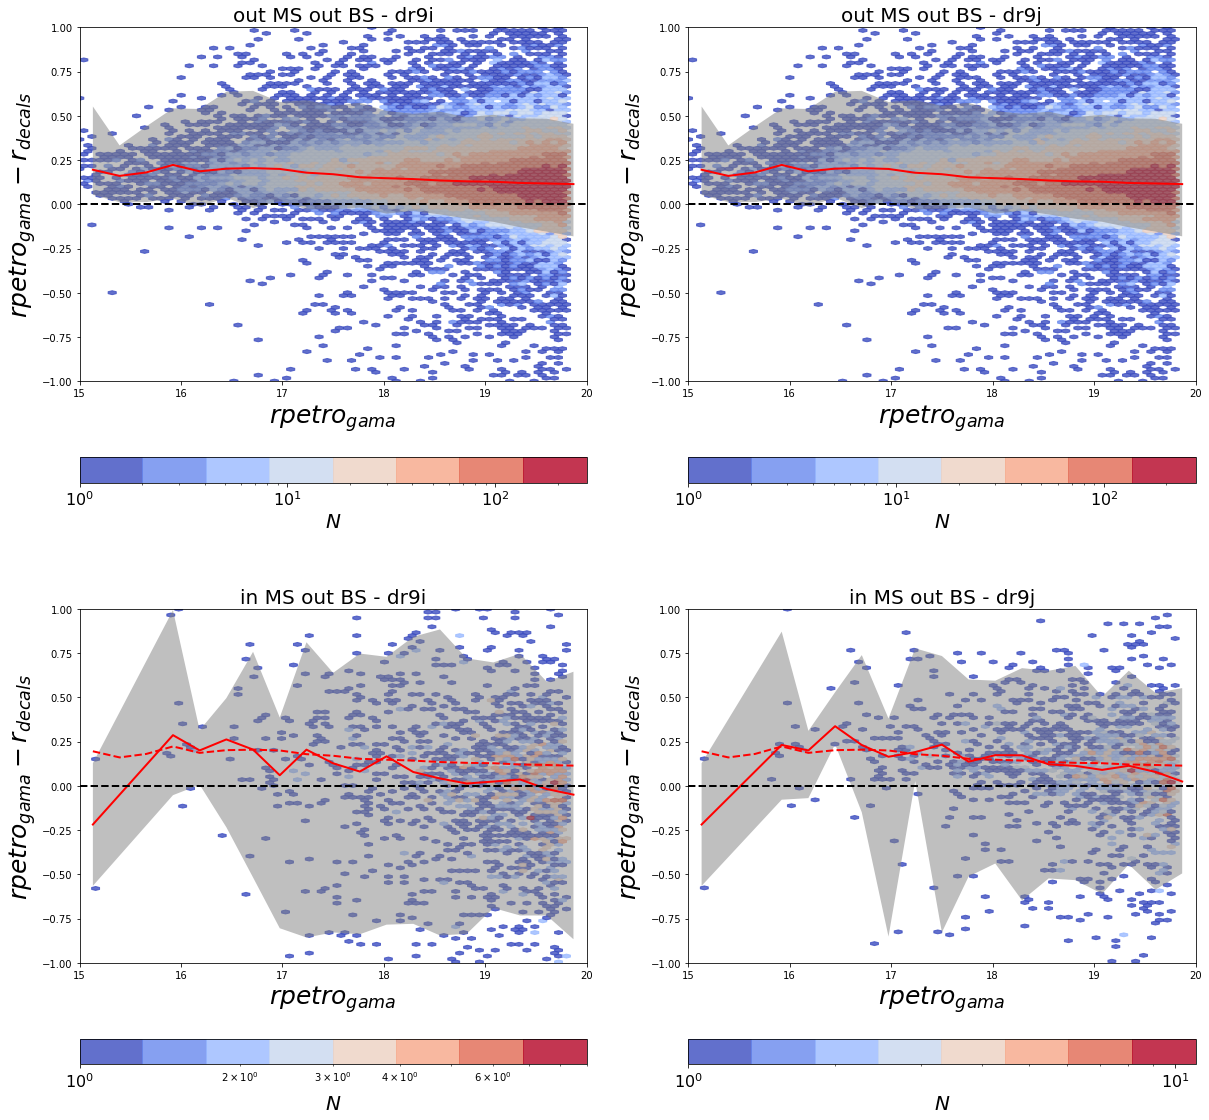

In [58]:
#
coord1 = {'$rpetro_{gama}$':cat1_rpetro, '$rpetro_{gama} - r_{decals}$':(cat1_rpetro - cat1['RMAG'])}
coord2 = {'$rpetro_{gama}$':cat2_rpetro, '$rpetro_{gama} - r_{decals}$':(cat2_rpetro - cat2['RMAG'])}

fig    = plt.figure(figsize=(10*2.,10*2.))
gs     = gridspec.GridSpec(2, 2, hspace=0.15, wspace=0.20)
cmap = plt.get_cmap('coolwarm', 8)

for num, title, mask, coord in zip([0,1,2,3], 
                            ['out MS out BS - %s' %(dr1), 'out MS out BS - %s' %(dr2), 'in MS out BS - %s' %(dr1), 'in MS out BS - %s' %(dr2)], 
                            [((outMS1) & (cat1_gama)), ((outMS2) & (cat2_gama)), ((inMS1) & (cat1_gama)), ((inMS2) & (cat2_gama))],
                            [coord1, coord2, coord1, coord2]):

    ax = hexbin(coord=coord, catmask=mask, n=num, bins='log', title=title, cmap=cmap, 
                   ylab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=None, vmax=None, mincnt=1, 
                       file=None, fracs=False, area=None, cbar='horizontal', xlim=[15, 20], ylim=[-1, 1], showmedian=True)
    
    if num == 0:
        binc, median = ax[1], ax[2]
        
    if num > 1:
        ax[0].plot(binc, median, lw=2, ls='--', c='r')

    ax[0].axhline(0, lw=2, ls='--', c='k')


In [45]:
#
def query(cat=None, stars=None):
    
    from QA import circular_mask_radii_func
    from io_ import query_catalog_mask, search_around

    #Dustin_radii's
    mag = np.linspace(0, 20, 50)
    BS_radii = []
    new_BS_radii = []
    for i,j in enumerate(mag):
        BS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
        new_BS_radii.append([j, 0.5 * np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
        
    #idx20, idx10, d2d0, d_ra0, d_dec0 = search_around(cat['RA'], cat['DEC'], 
    #                                                            stars['RA'], stars['DEC'], search_radius=20)

    #BS_t = query_catalog_mask(cat['RA'], cat['DEC'], stars, BS_radii, nameMag='MAG', diff_spikes=False, 
    #                             length_radii=None, widht_radii=None, return_diagnostics=True, bestfit=False, log=False)
    #
    BS_t = query_catalog_mask(cat['RA'], cat['DEC'], stars, BS_radii, nameMag='MAG', diff_spikes=False, 
                                 length_radii=None, widht_radii=None, return_diagnostics=True, bestfit=False, log=False)
    #masking radius for each object cloosest stars in cat
    mask_radii = circular_mask_radii_func(BS_t[1]['w1_source'], BS_radii, bestfit=False)
    #masking radius reescaled for each object
    mask_radii_res = BS_t[1]['d2d_source']/mask_radii
    
    return BS_t[1]['d2d_source'], mask_radii_res


In [76]:
#
from io_ import get_msmask, cut
masksources = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/dr8_sweep_whole_maskbitsources.npy')
#MS = masksources[get_svfields_ij(masksources['RA'], masksources['DEC'], survey=survey)]
delta = 5
MS = cut(211-delta, 224+delta, -2.0-delta, 3.0+delta, masksources)
%time starsMS = get_msmask(MS)

97 nearby objects
154954 Medium Bright Stars
CPU times: user 1.14 s, sys: 269 ms, total: 1.41 s
Wall time: 1.2 s


In [77]:
radii1, radii1_res = query(cat=cat1, stars=starsMS)
radii2, radii2_res = query(cat=cat2, stars=starsMS)

Total run time: 11.893329 sec
Total run time: 12.087565 sec


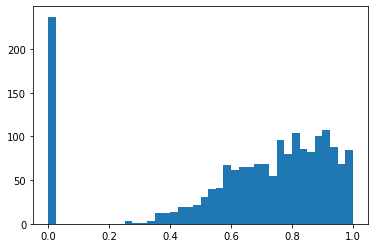

In [78]:
plt.hist(radii1_res[(inMS1) & (cat1_gama)], 40)
plt.show()

In [79]:
np.sum((inMS2) & (cat2_gama) & (radii2 == 0))

237

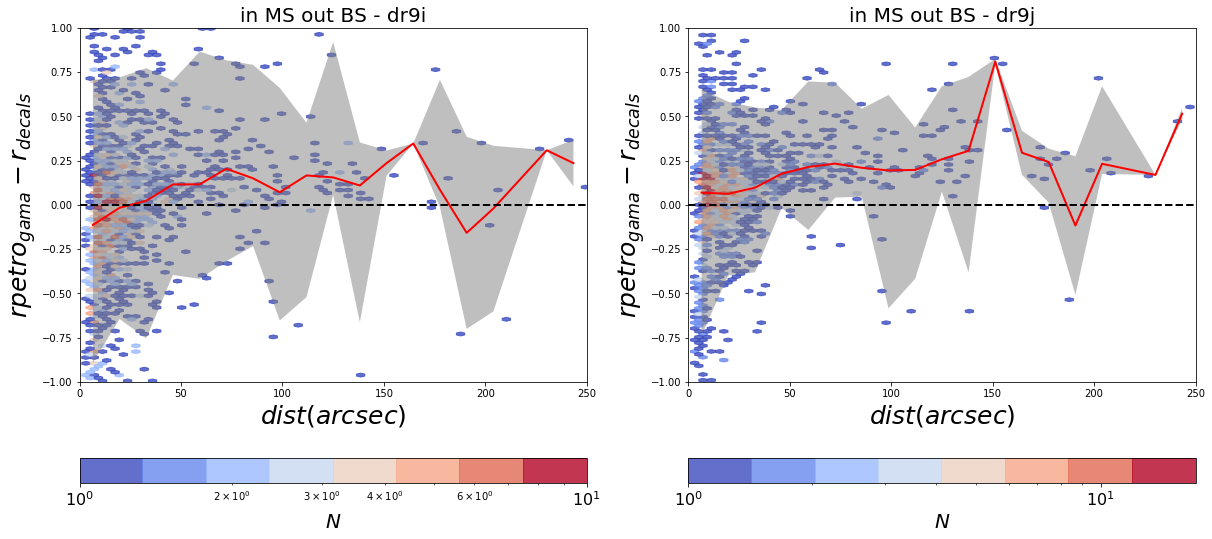

In [83]:
#
coord1 = {'$dist (arcsec)$':radii1, '$rpetro_{gama} - r_{decals}$':(cat1_rpetro - cat1['RMAG'])}
coord2 = {'$dist (arcsec)$':radii2, '$rpetro_{gama} - r_{decals}$':(cat2_rpetro - cat2['RMAG'])}

fig    = plt.figure(figsize=(10*2.,10*2.))
gs     = gridspec.GridSpec(2, 2, hspace=0.15, wspace=0.20)
cmap = plt.get_cmap('coolwarm', 8)

for num, title, mask, coord in zip([0,1], 
                            ['in MS out BS - %s' %(dr1), 'in MS out BS - %s' %(dr2)], 
                            [((inMS1) & (cat1_gama) & (radii1 > 0)), ((inMS2) & (cat2_gama) & (radii2 > 0))],
                            [coord1, coord2]):

    ax = hexbin(coord=coord, catmask=mask, n=num, bins='log', title=title, cmap=cmap, 
                   ylab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=None, vmax=None, mincnt=1, 
                       file=None, fracs=False, area=None, cbar='horizontal', xlim=[0, 250], ylim=[-1, 1], showmedian=True)

    ax[0].axhline(0, lw=2, ls='--', c='k')


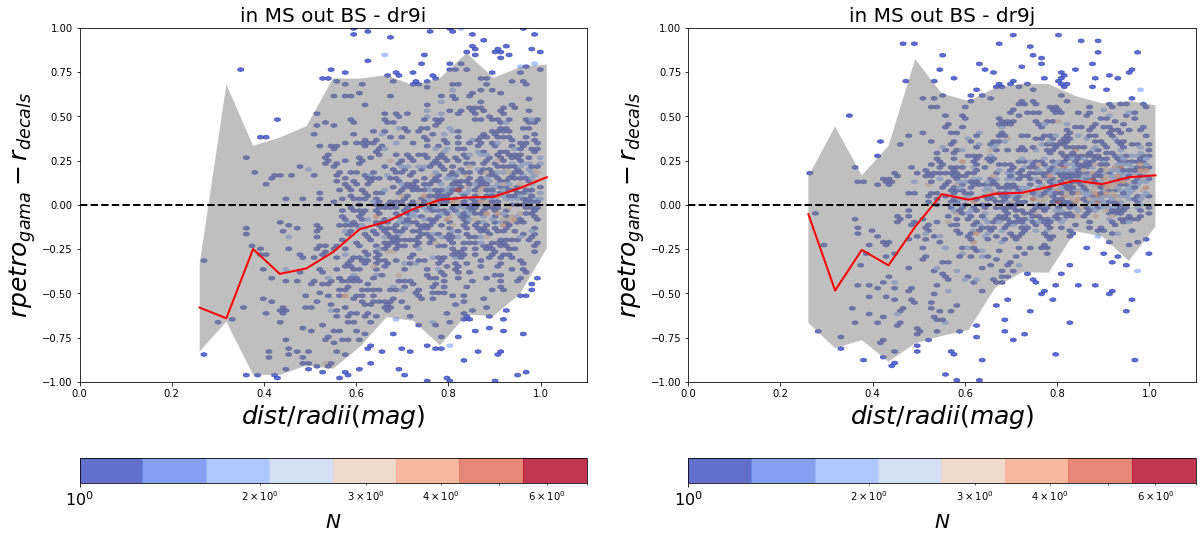

In [84]:
#
coord1 = {'$dist/radii(mag)$':radii1_res, '$rpetro_{gama} - r_{decals}$':(cat1_rpetro - cat1['RMAG'])}
coord2 = {'$dist/radii(mag)$':radii2_res, '$rpetro_{gama} - r_{decals}$':(cat2_rpetro - cat2['RMAG'])}

fig    = plt.figure(figsize=(10*2.,10*2.))
gs     = gridspec.GridSpec(2, 2, hspace=0.15, wspace=0.20)
cmap = plt.get_cmap('coolwarm', 8)

for num, title, mask, coord in zip([0,1], 
                            ['in MS out BS - %s' %(dr1), 'in MS out BS - %s' %(dr2)], 
                            [((inMS1) & (cat1_gama) & (radii1 > 0)), ((inMS2) & (cat2_gama) & (radii2 > 0))],
                            [coord1, coord2]):

    ax = hexbin(coord=coord, catmask=mask, n=num, bins='log', title=title, cmap=cmap, 
                   ylab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=None, vmax=None, mincnt=1, 
                       file=None, fracs=False, area=None, cbar='horizontal', xlim=[0, 1.1], ylim=[-1, 1], showmedian=True)

    ax[0].axhline(0, lw=2, ls='--', c='k')


In [87]:
#
from postages_images import html_postages
bgs_any = ((cat1['BGSBITS'] & 2**(20)) != 0)

veto = {'BGS & gama':(bgs_any) & (cat1_gama),'Not BGS & gama':(~bgs_any) & (cat1_gama), 'BGS & not gama':(bgs_any) & (~cat1_gama), 'not BGS & not gama':(~bgs_any) & (~cat1_gama)}

layer_list = ['%s-%s' %(dr1, survey), '%s-%s-model' %(dr1, survey), '%s-%s-resid' %(dr1, survey)]

mask = ((inMS1) & (cat1_gama) & (radii_res > 0) & (radii_res < 0.5))
#mask = ((inMS1) & (cat1_gama) & (radii == 0))

idx = list(np.where(mask))[0]
print('sample size: %i' %(len(idx)))
        
name = 'test'
html_postages(cat=cat1, coord=[cat1['RA'], cat1['DEC']], idx=idx, notebook=True, savefile=pathdir+'/%s' %(name), 
              htmltitle='/%s' %(name), veto=veto, grid=[2,6], m=4, radius=4/3600, 
                  comparison=None, layer_list=layer_list)

sample size: 104


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr9i_dr9j-south_svfields_ij_0.1.0_comparison/test.html
32.0 122


In [ ]:
print('bgs dr9g not bgs dr9f inside MS outside BS and in G15 (matched with GAMA / all): \t %i / %i = %.2f' %(len(idx2), np.sum(mask), len(idx2)/np.sum(mask)))

### Comparing morphologies with Heatmaps

In [28]:
#
morphs_2 = {}
morphs_1 = {}
mask = (match)

for i in ['REX', 'EXP', 'DEV', 'SER', 'PSF']:
    
    morphs_2[i] = (mask) & (tab['TYPE_%s' %(dr2[-1])] == i)
    morphs_1[i] = (mask) & (tab['TYPE_%s' %(dr1[-1])] == i)


In [29]:
import seaborn as sns
def heatmap(data1, data2, vmin=None, vmax=None, file=None, ticks=None, fmt=".1f", mask=None, Area=None, log=False, cat1name=None, cat2name=None):
    
    import pandas as pd
    from matplotlib.colors import LogNorm
    N = len(data1.keys())
    keylist = list(data1.keys())
    matrix = [[0 for x in range(N)] for y in range(N)]
    if mask is None: mask = np.ones_like(data1[keylist[0]], dtype=bool)
    
    from itertools import product
    for i,j in product(range(N), range(N)):
        
        matrix[i][j] = np.sum((data1[keylist[i]]) & (data2[keylist[j]]) & (mask))/Area
        #print(keylist[i], keylist[j], matrix[i][j]) #sanity check
        
    keylist_g = [i+'_%s' %(cat2name) for i in keylist]
    keylist_f = [i+'_%s' %(cat1name) for i in keylist]
    df = pd.DataFrame(np.array(matrix), columns=keylist_f, index=keylist_g)
    #df = pd.DataFrame(np.tril(np.array(matrix)), columns=keylist, index=keylist)
    #df.replace(0, np.nan, inplace=True)
    
    if ticks is None: ticks = np.linspace(vmin, vmax, 5)
    
    fig = plt.figure(figsize=(12,10))
    log_norm = LogNorm(vmin=df.min().min(), vmax=df.max().max())
    if log: norm = log_norm
    else: norm = None
    ax = sns.heatmap(df, annot=True, annot_kws={"size": 14}, fmt=fmt, linewidths=.5, cmap='Reds',
                   norm=norm,
                    vmin = vmin, vmax=vmax,
                        cbar_kws={"ticks":ticks, 'label': r'objects/deg$^2$'})
    ax.figure.axes[-1].yaxis.label.set_size(22)
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    
    if file is not None:
        fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)
        

In [30]:
#check if labels are correct
if False:
    test = (((MS1) | (MS2)) & (~BS1) & (~BS2) & (morphs_2['EXP']) & (morphs_1['REX']))
    np.sum(test)/area

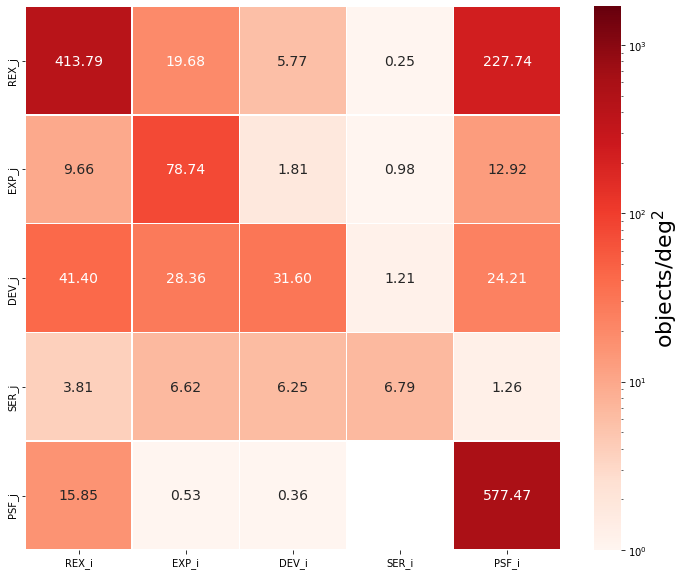

In [31]:
heatmap(morphs_2, morphs_1, vmin=1, vmax=1700, file=pathdir+'all_inside_morphs_heatmap', ticks=[1, 10, 100, 1000], 
        fmt=".2f", Area=area, log=True, mask = (((MS1) | (MS2)) & (~BS1) & (~BS2)), cat1name=dr1[-1], cat2name=dr2[-1])

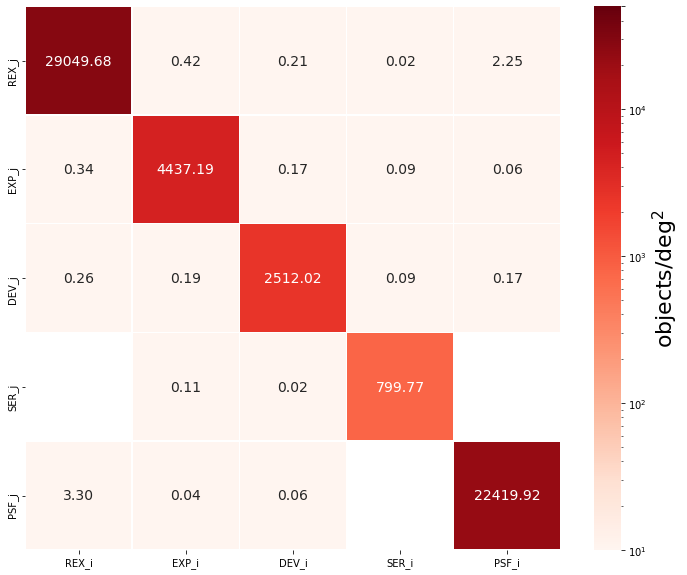

In [32]:
heatmap(morphs_2, morphs_1, vmin=10, vmax=50000, file=pathdir+'all_outside_morphs_heatmap', ticks=[1, 10, 100, 1000, 10000, 50000], 
        fmt=".2f", Area=area, log=True, mask = (~((MS1) | (MS2)) & (~BS1) & (~BS2)), cat1name=dr1[-1], cat2name=dr2[-1])

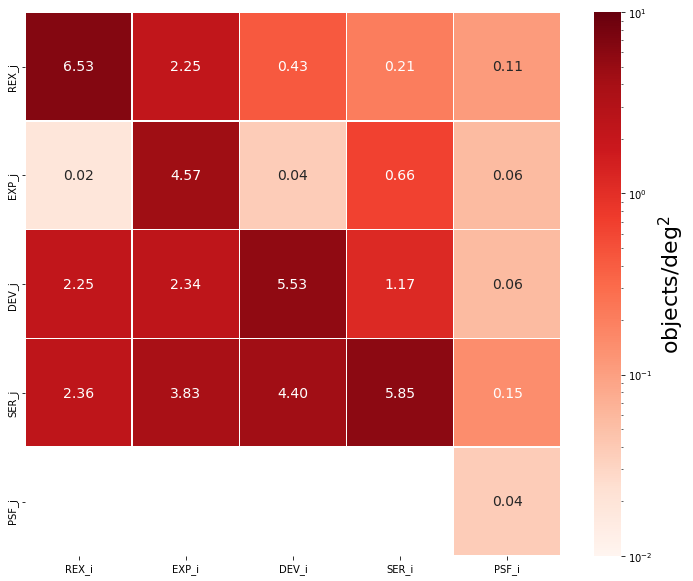

In [33]:
heatmap(morphs_2, morphs_1, vmin=0.01, vmax=10, file=pathdir+'bgs_inside_morphs_heatmap', ticks=[0.01, 0.1, 1, 10], 
        fmt=".2f", Area=area, log=True, mask = (((MS1) | (MS2)) & (~BS1) & (~BS2) & (bgs2) & (match)), cat1name=dr1[-1], cat2name=dr2[-1])

In [34]:
#
if True:
    np.save(pathdir+'/all', tab)
    #np.save(pathdir+'/in', tab_in)
    #np.save(pathdir+'/out', tab_out)

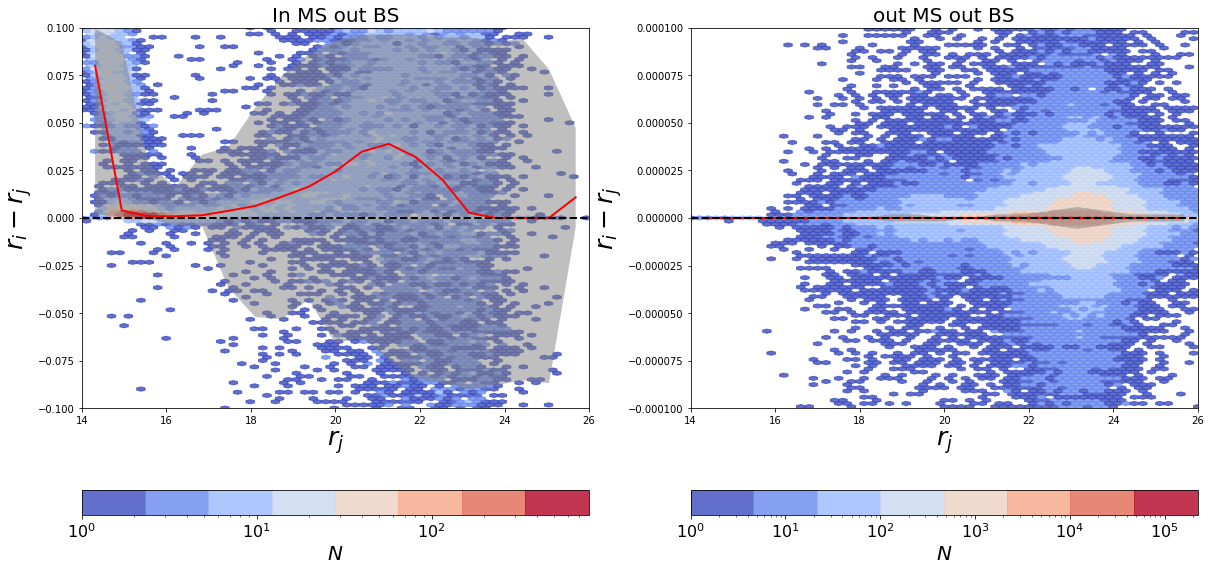

In [35]:
#(match) & (bgsg) & (~bgsf) & (MSf) & (MSg) & (~BSf) & (~BSg)
coord = {'$r_{%s}$' %(dr2[-1]):tab['RMAG_%s' %(dr2[-1])], '$r_{%s} - r_{%s}$' %(dr1[-1], dr2[-1]):(tab['RMAG_%s' %(dr1[-1])] - tab['RMAG_%s' %(dr2[-1])])}
#coord_out = {'$r_{g}$':tab['RMAG_g'], '$r_{f} - r_{g}$':(tab['RMAG_f'] - tab['RMAG_g'])}
mask_in = ((MS1) | (MS2)) & (~BS1) & (~BS2)
mask_out = (~((MS1) | (MS2))) & (~BS1) & (~BS2)

fig    = plt.figure(figsize=(10*2.,10*1.))
gs     = gridspec.GridSpec(1, 2, hspace=0.15, wspace=0.20)
cmap = plt.get_cmap('coolwarm', 8)

ax = hexbin(coord=coord, catmask=((match) & (mask_in)), n=0, bins='log', title='In MS out BS', cmap=cmap, 
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=None, vmax=None, mincnt=1, 
                   file=None, fracs=False, area=None, cbar='horizontal', xlim=[14, 26], ylim=[-.1, .1], showmedian=True)
        
ax.axhline(0, lw=2, ls='--', c='k')


ax = hexbin(coord=coord, catmask=((match) & (mask_out)), n=1, bins='log', title='out MS out BS', cmap=cmap, 
               ylab=True, vline=None, hline=None, fig=fig, gs=gs, vmin=None, vmax=None, mincnt=1, 
                   file=None, fracs=False, area=None, cbar='horizontal', xlim=[14, 26], ylim=[-.0001, .0001], showmedian=True)
        
ax.axhline(0, lw=2, ls='--', c='k')



## Gallery

In [36]:
#
tabgall = Table()

indr92 = np.where(tab['dr9%s' %(dr2[-1])])
indr91 = np.where((tab['dr9%s' %(dr1[-1])]) & (~tab['dr9%s' %(dr2[-1])]))

for key in ['RA', 'DEC', 'RMAG', 'GMAG', 'ZMAG', 'REF_CAT', 'TYPE']:
    
    if isinstance(tab[key+'_%s' %(dr2[-1])][0], (str)): col = np.full(len(tab['dr9%s' %(dr2[-1])]), np.nan, dtype=str)
    else: col = np.full(len(tab['dr9%s' %(dr2[-1])]), np.nan)
    
    col[indr92] = tab[key+'_%s' %(dr2[-1])][indr92]
    col[indr91] = tab[key+'_%s' %(dr1[-1])][indr91]
    
    tabgall[key] = col
    

In [37]:
#
from postages_images import html_postages

coord = [tabgall['RA'], tabgall['DEC']]
veto = {'in both':((tab['dr9%s' %(dr2[-1])]) & (tab['dr9%s' %(dr1[-1])])),
        'dr9%s only' %(dr1[-1]):((~tab['dr9%s' %(dr2[-1])]) & (tab['dr9%s' %(dr1[-1])])),
        'dr9%s only' %(dr2[-1]):((tab['dr9%s' %(dr2[-1])]) & (~tab['dr9%s' %(dr1[-1])]))
       }

layer_list = ['dr9%s-%s' %(dr1[-1], survey), 'dr9%s-%s-model' %(dr1[-1], survey), 'dr9%s-%s-resid' %(dr1[-1], survey), 
              'dr9%s-%s' %(dr2[-1], survey), 'dr9%s-%s-model' %(dr2[-1], survey), 'dr9%s-%s-resid' %(dr2[-1], survey)]

#layer = 'dr9g'+'-'+survey
    
select = (match) & (bgs2) & (~bgs1) & ((MS1) | (MS2)) & (~BS1) & (~BS2) & (tab['RMAG_%s' %(dr2[-1])] < 19.5)
#select = (tab['dr9g']) & (~tab['dr9f']) & (bgsg) & (MSg) & (~BSg)
idx = list(np.where(select))[0]
print('sample size: %i' %(len(idx)))

#info = {'r':cat['RMAG'], 'T':cat['TYPE'].astype(str), 'ref':cat['REF_CAT'].astype(str)}

html_postages(cat=tab, coord=coord, idx=idx, notebook=True, savefile=pathdir+'/bgs_dr9%s_not_dr9%s_r<19.5' %(dr2[-1], dr1[-1]), 
              htmltitle='/bgs_dr9%s_not_dr9%s_r<19.5' %(dr2[-1], dr1[-1]), veto=veto, grid=[10,6], m=4, radius=4/3600, 
                  comparison=[dr1[-1], dr2[-1]], layer_list=layer_list)


sample size: 173


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr9i_dr9j-north_svfields_ij_0.1.0_comparison/bgs_dr9j_not_dr9i_r<19.5.html
32.0 122


In [39]:
#
from postages_images import html_postages

coord = [tabgall['RA'], tabgall['DEC']]
veto = {'in both':((tab['dr9%s' %(dr2[-1])]) & (tab['dr9%s' %(dr1[-1])])),
        'dr9%s only' %(dr1[-1]):((~tab['dr9%s' %(dr2[-1])]) & (tab['dr9%s' %(dr1[-1])])),
        'dr9%s only' %(dr2[-1]):((tab['dr9%s' %(dr2[-1])]) & (~tab['dr9%s' %(dr1[-1])]))
       }

layer_list = ['dr9%s-%s' %(dr1[-1], survey), 'dr9%s-%s-model' %(dr1[-1], survey), 'dr9%s-%s-resid' %(dr1[-1], survey), 
              'dr9%s-%s' %(dr2[-1], survey), 'dr9%s-%s-model' %(dr2[-1], survey), 'dr9%s-%s-resid' %(dr2[-1], survey)]

#layer = 'dr9g'+'-'+survey
    
select = (match) & (~bgs2) & (bgs1) & ((MS1) | (MS2)) & (~BS1) & (~BS2) & (tab['RMAG_%s' %(dr1[-1])] < 19.5)
#select = (tab['dr9g']) & (~tab['dr9f']) & (bgsg) & (MSg) & (~BSg)
idx = list(np.where(select))[0]
print('sample size: %i' %(len(idx)))

#info = {'r':cat['RMAG'], 'T':cat['TYPE'].astype(str), 'ref':cat['REF_CAT'].astype(str)}

html_postages(cat=tab, coord=coord, idx=idx, notebook=True, savefile=pathdir+'/bgs_dr9%s_not_dr9%s_r<19.5' %(dr1[-1], dr2[-1]), 
              htmltitle='/bgs_dr9%s_not_dr9%s_r<19.5' %(dr1[-1], dr2[-1]), veto=veto, grid=[3,6], m=4, radius=4/3600, 
                  comparison=[dr1[-1], dr2[-1]], layer_list=layer_list)


sample size: 21


Loading BokehJS ...

/global/project/projectdirs/desi/users/qmxp55/bgstargets/doc/dr9i_dr9j-north_svfields_ij_0.1.0_comparison/bgs_dr9i_not_dr9j_r<19.5.html
32.0 122


# DEV ZONE...